In [1]:
import site
site.addsitedir('../')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from astropy.io import fits
from IPython.display import YouTubeVideo
from tools.resample_flux import trapz_rebin
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## <span style="color:#3E2D80">Creando un cerebro artifical para encontrar la más temperamental de las bestias astronómicas</span>

Si crees que Nueva York es un lugar ajetreado, ¡piénsalo de nuevo! El espacio está lleno de cosas que chocan continuamente en la noche. Durante su estudio de cinco años, DESI tendrá la oportunidad de atrapar a miles de las bestias astronómicas más temperamentales del Universo, desde [estrellas en explosión](https://es.wikipedia.org/wiki/Supernova) a [fusionando estrellas de neutrones y estrellas negras agujeros](https://es.wikipedia.org/wiki/Kilonova) y [estrellas destrozadas por agujeros negros](https://es.wikipedia.org/wiki/Evento_de_disrupci%C3%B3n_de_marea), sin mencionar una larga lista de otros eventos fantásticos.

Los científicos de DESI son inteligentes, ¡pero ni siquiera ellos pueden identificar todos estos casi > 30 millones de espectros! Afortunadamente, tenemos expertos que saben cómo crear cerebros artificiales, o redes neuronales, construidas para especializarse en tareas como esta. En este cuaderno, [Segev Ben Zvi](https://www.pas.rochester.edu/~sybenzvi/),

<img src="../images/Segev.jpg" alt="Drawing" style="width: 400px;"/>

nos pondrá al día con el aprendizaje automático de vanguardia y cómo se usa en esta búsqueda. Las supernovas (de tipo Ia) son las más críticas para la cosmología, así que primero nos centraremos en cómo identificarlas (a simple vista), ¡luego enseñaremos a trozos de silicio a hacerlo!

### Supernovas de colapso del núcleo

En casi todos los casos, las supernovas son la etapa final del ciclo de vida de las estrellas más masivas (> 10 $ M_{\odot} $, 10 veces mayor que la masa del Sol). Finalmente, el combustible disponible que sostiene la fusión nuclear en el núcleo se agota y la energía utilizada para soportar la capa más externa desaparece. Entonces, inevitablemente, la estrella colapsa por su propio peso en una violenta explosión que dura solo una fracción de segundo. Una estrella de neutrones quedará atrás o, si la estrella progenitora es lo suficientemente masiva, incluso un [agujero negro](https://es.wikipedia.org/wiki/Agujero_negro).

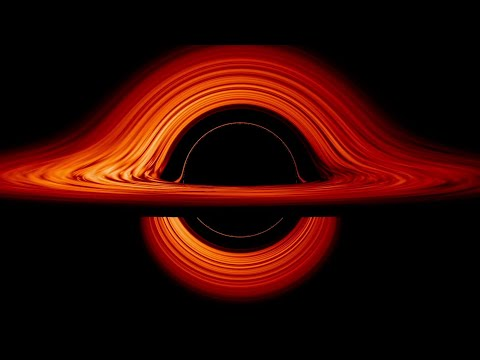

In [2]:
YouTubeVideo('o-Psuz7u5OI', width=800, height=400)

### Supernovas binarias

No todas las supernovas surgen debido al colapso del núcleo. En sistemas binarios con una enana blanca compacta y una estrella envejecida (secuencia principal), la enana blanca puede atraer material gravitacionalmente desde la capa de su compañera. Si se acumula suficiente material en la superficie de la enana blanca para que su masa total exceda el [límite de Chandrasekhar](https://es.wikipedia.org/wiki/L%C3%ADmite_de_Chandrasekhar), 1.44 $ M_\odot $, entonces ocurre una reacción nuclear descontrolada que hace explotar la Enana Blanca en una explosión intensamente brillante. ¡Estas llamadas supernovas de tipo Ia son la razón por la que descubrimos la Energía Oscura en primer lugar!

<img src="../images/type1a.jpg" alt="Drawing" style="width: 400px;"/>

Estos diferentes tipos de supernova se distinguen por su brillo cambiante con el tiempo, su _'curva de luz'_, pero si tenemos el espectro de la supernova, es mucho menos probable que cometamos un error. Cada espectro de supernova tiene líneas muy amplias distintas tanto en emisión como en absorción (Si II, H $\alpha$, Ca II, etc.), del gas caliente que escapa de la explosión central a alta velocidad. Estas "huellas" permiten distinguir los distintos tipos.

<img src="../images/sne_filippenko.png" width="600px"/>

¿Puedes decir qué es diferente entre estos cuatro ejemplos? ¿Tienen líneas en común y diferencias? Durante muchas décadas, los astrónomos han seguido esta lógica y la han dividido en una clasificación de supernovas, lo que nos dice el mecanismo detrás de su origen.

<img src="../images/SupernovaeClassification.png" width="600px"/>

Por ejemplo, una supernovas de tipo Ib no muestra líneas de hidrógeno (H), pero sí las de helio.

##  Cátalogo de Galaxias Brillantes de DESI (Bright Galaxy Survey)

Para ser lo suficientemente brillantes como para ser detectadas, las supernovas deben vivir en una galaxia relativamente cercana, como Messier 101,

<img src="../images/type1aBGS.jpg" alt="Drawing" style="width: 400px;"/>

Con su estudio de diez millones de galaxias en el Universo _local_, el DESI Bright Galaxy Survey será perfecto para encontrarlas, ya que la luz recolectada por cualquier fibra dada será el total de la galaxia y la luz de una supernova potencial,

<img src="../images/Messier101.png" alt="Drawing" style="width: 400px;"/>

donde vemos la misma galaxia Messier 101 en las imágenes Legacy de DESI y el área sobre la cual la luz es recolectada por las fibras (círculos). No sabremos de antemano si hay supernovas allí, por supuesto, así que esto solo funciona ya que DESI observará muchas galaxias y la tasa de supernovas en el Universo es relativamente alta, ¡así que tenemos buenas probabilidades!

Veamos cómo se ve esto en la práctica.

###  ¿Qué ve DESI?

In [3]:
# Abrimos el archivo y vemos su contenido básico
hdus = fits.open('../dat/bgs-supernovae.fits')
hdus.info()

Filename: ../dat/bgs-supernovae.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  WAVE          1 PrimaryHDU       8   (6265,)   float64   
  1  FLUX          1 ImageHDU         8   (6265, 6)   float64   
  2  IVAR          1 ImageHDU         8   (6265, 6)   float64   
  3  MASK          1 ImageHDU        10   (6265, 6)   int32 (rescales to uint32)   
  4  SPECTYPE      1 BinTableHDU     11   6R x 1C   [10A]   


Here _WAVE_ is simply an array of the observed wavelengths, 

In [4]:
hdus['WAVE'].data

array([3569.60009766, 3570.60009766, 3571.60009766, ..., 9831.59960938,
       9832.59960938, 9833.59960938])

_FLUX_ es la intensidad de luz observada y _IVAR_ es $ (1\ / \ \rm{varianza \ esperada }) $ del flujo, es decir, de esto podemos derivar el error en este flujo observado. ¿Puedes pensar cómo? Dada la forma,

In [5]:
hdus['FLUX'].data.shape

(6, 6265)

vemos que tenemos el flujo medido a las mismas longitudes de onda que las de arriba, para seis objetivos.

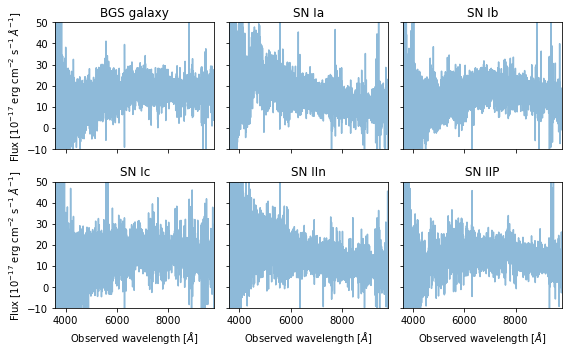

In [6]:
# Graficamos todos los espectros en la misma cuadrícula de longitud de onda.
fig, axes = plt.subplots(2,3, figsize=(8,5), sharex=True, sharey=True, tight_layout=True)

for i, ax in enumerate(axes.flatten()):
    wave = hdus['WAVE'].data
    flux = hdus['FLUX'].data[i]
    ivar = hdus['IVAR'].data[i]
    spec = hdus['SPECTYPE'].data[i][0]
    
    ax.plot(wave, flux, alpha=0.5)
    ax.set(xlim=(3600, 9800), ylim=(-10,50),
           title=spec)

axes[0,0].set(ylabel=r'Flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]');
axes[1,0].set(ylabel=r'Flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]');

for i in range(0,3):
    axes[1,i].set(xlabel=r'Observed wavelength [$\AA$]')

Estos son los flujos observados por una fibra determinada de DESI, después de haber removido la luz conocida de la atmósfera. En la parte superior izquierda, tenemos la luz emitida por una galaxia BGS típica. Los otros paneles contienen la luz de la galaxia de un tipo específico de supernovas en cada caso. ¡Lo primero que hay que notar es que esto es _mucho_ menos claro de lo que esperábamos del espectro de ejemplo anterior!

Entonces, ¿cómo podemos confirmar que la luz de las supernovas de cada tipo (Ib, Ic, IIn, IIP) está realmente allí, como se confirma?

## Menos es más

Nuestro "problema" es que DESI mide la cantidad de luz en intervalos muy pequeños en longitud de onda (o color), debido a su alta resolución. Los espectros de objetivos específicos, en este caso supernovas, pueden no cambiar mucho en un intervalo de longitud de onda pequeño, por lo que terminamos con muchas mediciones _ruidosas_ de la misma cosa: la intensidad de la luz en un color o longitud de onda promedio.

Esto es _genial_, ya que podemos ser inteligentes y simplemente combinar estas medidas para obtener un valor promedio que es mucho más _preciso_.

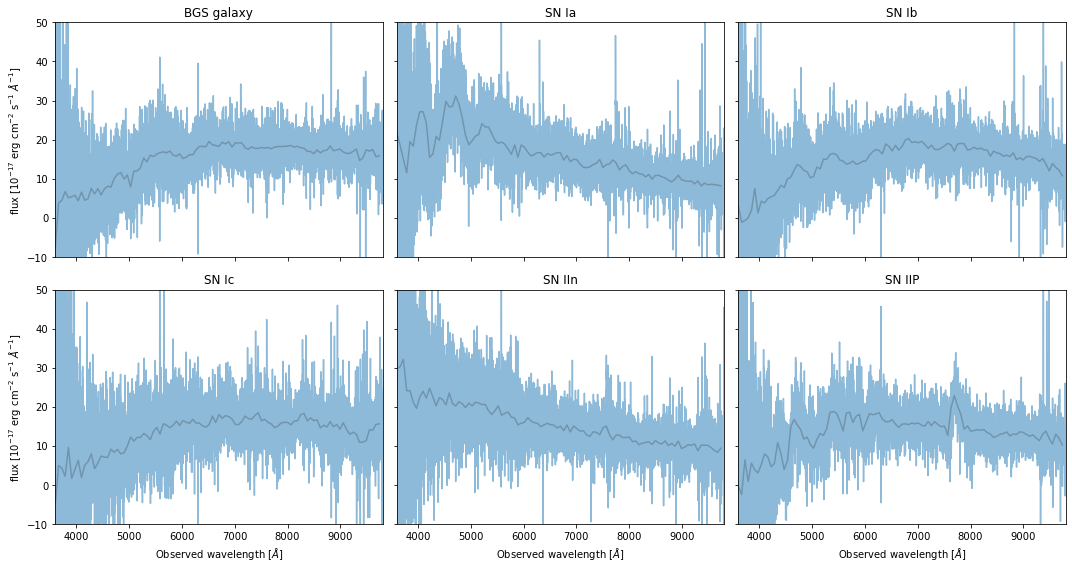

In [7]:
# Graficamos todos los espectros en la misma cuadrícula de longitud de onda.
fig, axes = plt.subplots(2,3, figsize=(15,8), sharex=True, sharey=True, tight_layout=True)

# Remuestreamos el flujo en una nueva cuadrícula de longitud de onda con solo 100 bins.
coarse_wave = np.linspace(3600, 9800, 101)

for i, ax in enumerate(axes.flatten()):
    wave = hdus['WAVE'].data
    flux = hdus['FLUX'].data[i]
    ivar = hdus['IVAR'].data[i]
    spec = hdus['SPECTYPE'].data[i][0]
    
    ax.plot(wave, flux, alpha=0.5)
        
    fl   = trapz_rebin(wave, flux, edges=coarse_wave)
    
    ax.plot(coarse_wave[:-1], fl, 'k-', alpha=0.2)
    
    ax.set(xlim=(3600, 9800), ylim=(-10,50),
           title=spec)

axes[0,0].set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]');
axes[1,0].set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]');

for i in range(0,3):
    axes[1,i].set(xlabel=r'Observed wavelength [$\AA$]')

¡Y ahora vemos mucho mejor los deeps característicos, o líneas de absorción, de las supernovas! Por supuesto, este no es el único enfoque. Podríamos haber usado estadísticas y los datos originales 'no agrupados', pero las cosas siempre son mejores cuando son más transparentes. Sin embargo, sigue siendo complicado, ya que la velocidad de la estrella significa que las líneas de absorción no estarán donde las esperaríamos normalmente. En este sentido, hay _dos corrimientos al rojo_ en el espectro.

Así que hemos identificado con éxito una (¡simulada, por ahora!) Supernovas DESI, pero nunca pudimos inspeccionar visualmente el estudio completo de esta manera. Necesitamos un método más eficiente...

## Un cerebro artificial: donde la anatomía se encuentra con la astronomía

<img src="../images/AIBrain.jpg" alt="Drawing" style="width: 600px;"/>

Dada la increíble capacidad del cerebro humano, ¿a quién no se le ocurriría intentar comprenderlo y reproducirlo? Se logró un gran progreso en la década de 1940 con modelos simples que llevaron a los modelos de vanguardia de _aprendizaje profundo_ que han sido fundamentales para Google, Amazon y otras tecnologías hoy en día gigantes.

En las neuronas biológicas, las dendritas reciben señales de entrada de _miles_ de neuronas vecinas. Estas señales se _combinan_ en el núcleo y pasan a un axón. Solo si la señal combinada es _mayor que un valor de umbral_, entonces el axón liberará una señal prescrita.

<img src="../images/Dendrite.jpg" alt="Drawing" style="width: 600px;"/>

Este simple paso final es donde ocurre la magia. Antes de esto, la señal de salida es una simple suma ponderada de las señales de entrada, p. Ej. $ y = a \ cdot x + b $. Las posibilidades de esta configuración son relativamente limitadas.

El umbral hace que la señal sea _no lineal_, de modo que cuando la señal de entrada cambia en una _cantidad pequeña, dx_, la señal de salida puede cambiar en _mucho_. Esto, junto con el _gran número_ de neuronas (relativamente simples) en el cerebro permite un potencial casi ilimitado, representado por el rango de posibilidades de salida o ideas que pueden formarse. Mientras lees esto, hay _100 mil millones_ de neuronas que pueden disparar su imaginación. ¡Quién sabe lo que se te ocurra!

### Potencial ilimitado

El aprendizaje automático 'profundo' es donde estas ideas relativamente simples se encuentran con la potencia informática bruta que nos otorgó [John von Neumann](https://es.wikipedia.org/wiki/John_von_Neumann), [John Bardeen](https://es.wikipedia.org/wiki/John_Bardeen), ... Las cosas realmente despegaron cuando salió a la luz el [martillo](https://es.wikipedia.org/wiki/Unidad_de_procesamiento_gr%C3%A1fico) adecuado para el problema.

En un equipo, pero en esencia, la misma estructura, podemos tener una serie de valores de entrada, $ x_1, x_2, ... $, como lo que sería recogido por las dendritas, que se ponderan y se suma, $ a_1 \ cdot x 1 + a2 \ cdot x_2 + ... + b_1 \ cdot _ x2 + ... $ como en el axón. Esto puede suceder varias veces, en una serie de 'capas ocultas', donde la salida de la capa anterior actúa como entrada de la siguiente. En cualquier etapa, aunque normalmente es la última, la "magia" podría ser introducida, o de forma similar, en una capa determinada. Por lo general, esto se conoce como "activación", en analogía con el disparo de un axón.

<img src="../images/network.jpg" width="600px"/>

De antemano, o _a priori_, no tenemos idea de cuál debería ser el peso de nuestra 'red neuronal' artificial para un problema dado. La capacidad de la configuración está representada por el número de salidas diferentes que se pueden generar cuando cualquier peso determinado produce un nuevo número aleatorio, el resultado de lo que normalmente Será algo sin sentido para una entrada dada.

Pero si podemos definir el "éxito", como la satisfacción después de una buena comida o una broma, entonces podemos inculcar el "buen comportamiento" en los pesos. Introducimos repetidamente la red en un rango de escenarios diferentes y permitimos que los pesos, $ a_1, ..., b_1, ... $, o entidad, se refinen a aquellos que logran el _mayor éxito_, según se define en comparación con el 'verdad'. De esta manera, podemos replicar cientos de generaciones de [selección natural](https://es.wikipedia.org/wiki/Selecci%C3%B3n_natural) en una fracción de segundo.

### Si la vida fuera tan simple

El atractivo del aprendizaje profundo es claro, al igual que su potencial: ¿cuántas veces te has equivocado en tu vida? Claro, siempre estamos aprendiendo, pero la ciencia generalmente se basa en lo que sabemos y lo que no, dentro de lo razonable. No sobrevivirás demasiado tiempo en el campo si predices una respuesta diferente a la que tenías seis meses antes, ¡a pesar de lo mucho que hayas aprendido!

En otras palabras, lo más importante es saber lo que puedes decir _con confianza_. Normalmente, las redes neuronales harán una predicción definitiva, sin tener idea de su confianza y crecimiento potencial. Como tal, podríamos revisar nuestra ambición ...

### Potencial Limitado

Habiendo admitido nuestro potencial mundano, podríamos sacrificar algo de nuestra capacidad de ser perfectos, a favor de limitar el _potencial de equivocarnos_. Esto puede ser práctico, ya que una red con una gran cantidad de pesos puede ser infalible dada una potencia informática infinita, pero de lo contrario sería un desafío enorme.

Uno de los medios más efectivos para limitar el número de pesos en nuestra red y, por lo tanto, la posibilidad de estar equivocados, es reemplazar capas ocultas 'completamente conectadas' de pesos arbitrarios con capas 'convolucionales'. Una convolución simplemente reemplaza una cantidad de píxeles vecinos con un promedio ponderado, como en este caso.

<img src="../images/CMB-lensing.jpg" width="600px"/>

Así, no es algo muy diferente a una capa completamente conectada. Sin embargo, difiere en que los pesos aplicados dentro de la imagen son _constantes en toda la imagen_. En otras palabras, una capa "completamente conectada" permite un tamaño, forma y tipo de vidrio diferentes en cualquier posición dada de una imagen. Al restringirnos a 'un vaso', reducimos en gran medida el potencial de la red, tanto en su capacidad para tener razón como para estar equivocado.

De esta manera, hemos recurrido a [filtros adaptados](https://es.wikipedia.org/wiki/Filtro_adaptado) arbitrarios, conocidos pronto por la invención del radar y el sonar. Eso no quiere decir que no tengamos algunas capas completamente conectadas, lo que podría detectar anomalías que no son consistentes en una imagen determinada.

## El Evento Principal

Primero, simplemente abramos nuestro archivo de datos y enumeremos el resultado.

In [8]:
spectra = np.load('../dat/sn_simspectra.npz')
spectra.files

['wave', 'hosts', 'snia', 'snib', 'snic', 'sniip']

y descomprímamoslo en algo más explícito,

In [9]:
wave        = spectra['wave']

# Host galaxy.
host_fluxes = spectra['hosts']

snia_fluxes = spectra['snia']
snib_fluxes = spectra['snib']
snic_fluxes = spectra['snic']
snii_fluxes = spectra['sniip']

Como anteriormente, esto es simplemente espectros de galaxias (hospedaje de nuestras supernovas) de ejemplo, junto con ejemplos que contienen clases específicas de supernovas. Para ser concretos, tracemos un espectro de cada uno.

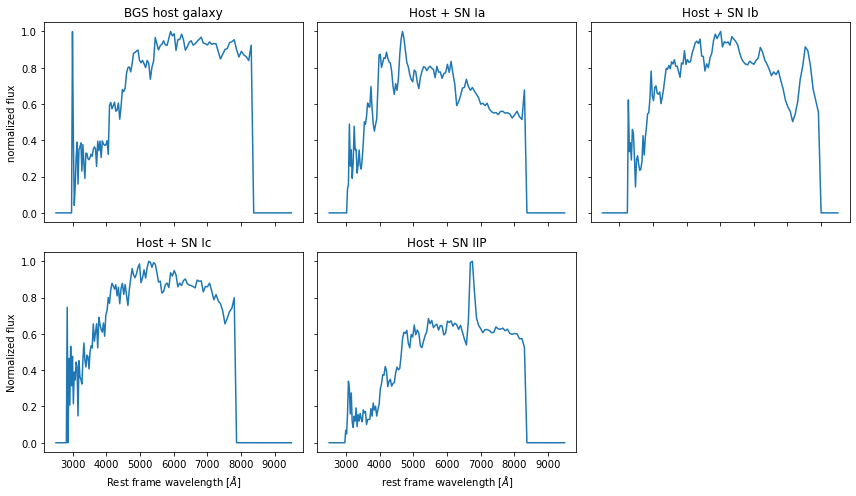

In [10]:
fig, axes = plt.subplots(2,3, figsize = (12,7), tight_layout=True, sharex=True, sharey=True)

ax = axes[0,0]
ax.plot(wave, host_fluxes[0])
ax.set(ylabel='normalized flux',
       title='BGS host galaxy')

ax = axes[0,1]
ax.plot(wave, snia_fluxes[0])
ax.set(title='Host + SN Ia')

ax = axes[0,2]
ax.plot(wave, snib_fluxes[0])
ax.set(title='Host + SN Ib')

ax = axes[1,0]
ax.plot(wave, snic_fluxes[0])
ax.set(xlabel=r'Rest frame wavelength [$\AA$]',
       ylabel='Normalized flux',
       title='Host + SN Ic')

ax = axes[1,1]
ax.plot(wave, snii_fluxes[0])
ax.set(xlabel=r'rest frame wavelength [$\AA$]',
       title='Host + SN IIP')

axes[1,2].axis('off');

Hay muchas posibilidades entre las que le estamos pidiendo a la red que busque. Para facilitar las cosas, estos espectros se han _precondicionado_. Para lograr esto, hemos: eliminado el efecto del corrimiento al rojo del espectro observado;
promediado en los contenedores vecinos, como anteriormente; renormalizado los flujos para que se encuentren entre [0, 1]; por lo tanto, ignoramos el brillo de las supernovas al determinar su tipo.

## Creando un cerebro artificial para encontrar las bestias astronómicas más temperamentales

Primero crearemos nuestro cerebro artificial y luego diseñaremos desafíos que pueda intentar repetidamente y _aprender_. Si usamos todos nuestros datos para crear los desafíos, entonces no tenemos datos externos para probar qué tan bien está funcionando la red; este sería un ejemplo clásico de [sobreajuste](https://es.wikipedia.org/wiki/Sobreajuste).

Para evitar esto, dividiremos nuestros datos en conjuntos de *entrenamiento* (train) y *validación* (test). Finalmente, para ser amigable con la computadora, asignaremos _etiquetas enteras_ simples a los tipos que esperamos que la red pueda adivinar: (host, Ia, Ib, Ic, IIp) = (0,1,2,3,4) respectivamente.

In [11]:
# Divide los datos en variables x y y, donde x = espectros y y = nuestras etiquetas.
nbins = len(wave)

x = np.concatenate([host_fluxes, 
                    snia_fluxes,
                    snib_fluxes,
                    snic_fluxes,
                    snii_fluxes
                   ]).reshape(-1, nbins, 1)

In [12]:
y = to_categorical(
        np.concatenate([np.full(len(host_fluxes), 0), 
                        np.full(len(snia_fluxes), 1),
                        np.full(len(snib_fluxes), 2),
                        np.full(len(snic_fluxes), 3),
                        np.full(len(snii_fluxes), 4)
                       ]))

In [13]:
x.shape, y.shape

((752, 150, 1), (752, 5))

In [14]:
# Dividiendo entre *entrenamiento* (train) y *validación* (test).
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.333)

### La red

Inicializaremos una red con un potencial limitado por tres capas convolucionales. Podría tener menos o más, según lo determinado por los pros y los contras anteriores. También vamos a optimizar la red en función de su _exactitud_, una métrica que maximiza el número de predicciones de la red que coinciden con la verdad. También podríamos entrenar en otras métricas como _precision_, que minimiza la cantidad de predicciones falsas; parece que debería ser lo mismo, pero [no](https://es.wikipedia.org/wiki/Precisi%C3%B3n_y_exhaustividad).

In [15]:
def network(input_shape, ncat, learning_rate=0.0005, reg=0.003, dropout=0.7, seed=None):
    """Definimos la estructura de la red convolucional.
    
    Párametros
    ----------
    input_shape : int
        Forma del espectro de entrada.
    ncat : int
        Numero de categorias o clases.
    learning_rate : float
        Tasa de Aprendizaje.
    reg : float
        Factor de Regularización.
    dropout : float
        Factor de perdida.
    seed : int
        Semilla de inicialización
    
    Retorno
    -------
    modelo : tensorflow.keras.Model
        Una instancia modelo de la red.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # Primera capa convolucional
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Segunda capa convolucional
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Tercera capa convolucional
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Capa aplanada completamente conectada
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Capa de salida con activación sigmoide
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Configura el optimizador, la función de pérdida y las métricas de optimización.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [16]:
# Definiremos la red aquí.
# La forma de entrada tendrá nbins = 150 bins de longitud de onda.
# El número de categorías está definido por la forma de nuestro vector y.
# Deberíamos tener cinco categorías (hosts, SN Ia, Ib, Ic y IIP).

cnn_model = network((nbins, 1), ncat=y.shape[1])

In [17]:
cnn_model.summary()

Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 150, 8)            48        
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 8)            32        
_________________________________________________________________
activation (Activation)      (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 16)            64    

Considere esto por un minuto. En total, hay 152,405 valores separados que se pueden entrenar en esta red. Eso es un poco menos de los ~10 mil millones en el suyo, ¡pero aún es mucho! Esto significa que existe un potencial considerable para que la red obtenga muy buenos espectros distintivos de candidatos a supernovas, pero que se necesitará mucho aprendizaje para obtener resultados sensibles.

### De pie sobre tus propios pies

Ahora, deja que suceda la magia. Dejaremos que la red aborde los desafíos y diseñe sus pesos, o neuronas, para maximizar la satisfacción o su capacidad para tener éxito.

In [18]:
history = cnn_model.fit(x_train, y_train, batch_size=50, epochs=125, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/125
11/11 [==============================] - 1s 136ms/step - loss: 2.8584 - accuracy: 0.1936 - val_loss: 2.7620 - val_accuracy: 0.2072
Epoch 2/125
11/11 [==============================] - 0s 43ms/step - loss: 2.7018 - accuracy: 0.2874 - val_loss: 2.7187 - val_accuracy: 0.2390
Epoch 3/125
11/11 [==============================] - 1s 51ms/step - loss: 2.6206 - accuracy: 0.3253 - val_loss: 2.6727 - val_accuracy: 0.2112
Epoch 4/125
11/11 [==============================] - 1s 52ms/step - loss: 2.5216 - accuracy: 0.3214 - val_loss: 2.6278 - val_accuracy: 0.2151
Epoch 5/125
11/11 [==============================] - 1s 50ms/step - loss: 2.4409 - accuracy: 0.3952 - val_loss: 2.5918 - val_accuracy: 0.2191
Epoch 6/125
11/11 [==============================] - 0s 42ms/step - loss: 2.4166 - accuracy: 0.4232 - val_loss: 2.5648 - val_accuracy: 0.2032
Epoch 7/125
11/11 [==============================] - 0s 45ms/step - loss: 2.2929 - accuracy: 0.4631 - val_loss: 2.5387 - val_accuracy: 0.2470
Epoch

11/11 [==============================] - 1s 52ms/step - loss: 1.0993 - accuracy: 0.8383 - val_loss: 1.7269 - val_accuracy: 0.6096
Epoch 59/125
11/11 [==============================] - 1s 63ms/step - loss: 1.0545 - accuracy: 0.8443 - val_loss: 1.5512 - val_accuracy: 0.6614
Epoch 60/125
11/11 [==============================] - 1s 47ms/step - loss: 1.0504 - accuracy: 0.8463 - val_loss: 1.5164 - val_accuracy: 0.6574
Epoch 61/125
11/11 [==============================] - 1s 64ms/step - loss: 1.0286 - accuracy: 0.8623 - val_loss: 1.4790 - val_accuracy: 0.6773
Epoch 62/125
11/11 [==============================] - 0s 45ms/step - loss: 1.0516 - accuracy: 0.8423 - val_loss: 1.5698 - val_accuracy: 0.6255
Epoch 63/125
11/11 [==============================] - 1s 62ms/step - loss: 1.0567 - accuracy: 0.8323 - val_loss: 1.5148 - val_accuracy: 0.6534
Epoch 64/125
11/11 [==============================] - 1s 53ms/step - loss: 1.0164 - accuracy: 0.8463 - val_loss: 1.4995 - val_accuracy: 0.6693
Epoch 65/125

11/11 [==============================] - 1s 54ms/step - loss: 0.8678 - accuracy: 0.9042 - val_loss: 1.4284 - val_accuracy: 0.6574
Epoch 116/125
11/11 [==============================] - 1s 53ms/step - loss: 0.8560 - accuracy: 0.8962 - val_loss: 1.4532 - val_accuracy: 0.6693
Epoch 117/125
11/11 [==============================] - 1s 71ms/step - loss: 0.8796 - accuracy: 0.9002 - val_loss: 1.5593 - val_accuracy: 0.6693
Epoch 118/125
11/11 [==============================] - 1s 61ms/step - loss: 0.8457 - accuracy: 0.8922 - val_loss: 1.4010 - val_accuracy: 0.6773
Epoch 119/125
11/11 [==============================] - 1s 52ms/step - loss: 0.8068 - accuracy: 0.9222 - val_loss: 1.4031 - val_accuracy: 0.6853
Epoch 120/125
11/11 [==============================] - 0s 38ms/step - loss: 0.7949 - accuracy: 0.9281 - val_loss: 1.5546 - val_accuracy: 0.6295
Epoch 121/125
11/11 [==============================] - 1s 78ms/step - loss: 0.9127 - accuracy: 0.8862 - val_loss: 1.5355 - val_accuracy: 0.6175
Epoch 

### ¿Pro o no pro?

Cada vez que la red intenta aprender, el desafío se conoce como una "época". A medida que aprende, deberíamos preocuparnos por la pérdida: una medida de qué tan mal la red está identificando nuestros espectros, que queremos minimizar. Considerando que, la precisión mide qué tan bien lo hace la red para identificar las cinco clases diferentes simuladas, siendo esto lo que queremos maximizar.

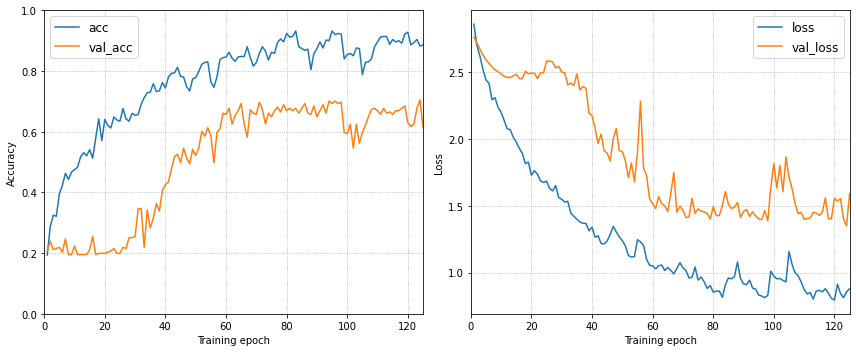

In [19]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(history.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, history.history['accuracy'], label='acc')
ax.plot(epochs, history.history['val_accuracy'], label='val_acc')
ax.set(xlabel='Training epoch',
       ylabel='Accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, history.history['loss'], label='loss')
ax.plot(epochs, history.history['val_loss'], label='val_loss')
ax.set(xlabel='Training epoch',
       ylabel='Loss',
       xlim=(0, nepoch),
#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout();

Podemos ver que la red aprendió inicialmente muy rápido, pero la mejora se ralentizó alrededor de 50 épocas más o menos. En este punto, la precisión alcanzada fue de alrededor del 70%, ¡así que no está mal!

### Matriz de confusión

En este tipo de clasificación, otra forma de medir el éxito es mediante la _matriz de confusión_,

In [20]:
# Vamos a utilizar la muestra de prueba para probar las predicciones de nuestra
# CNN entrenada ahora que ha "aprendido" a distinguir los diferentes tipos de
# supernovas. Esto no es ideal ... deberíamos tener una tercer
# muestra independiente de las muestras de entrenamiento y prueba.
y_pred = cnn_model.predict(x_test)

# En el clasificador de clases múltiples, evalue el máximo de
# coincidencias en la matriz de salida de valores.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

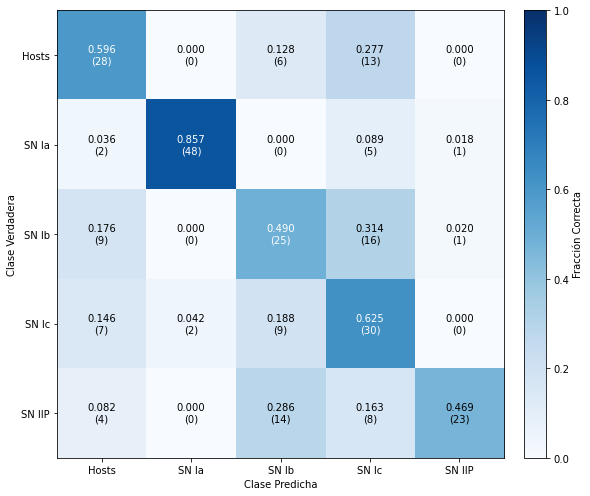

In [21]:
fig, ax = plt.subplots(1,1, figsize=(8,7))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('Fracción Correcta')

labels = ['Hosts', 'SN Ia', 'SN Ib', 'SN Ic', 'SN IIP']

ax.set(aspect='equal',
       xlabel='Clase Predicha',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='Clase Verdadera',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()

Si la CNN es perfecta para clasificar todas las categorías, entonces la entrada 'Etiqueta verdadera' y la salida de 'Etiqueta predicha' de la red coincidirían siempre. En este caso, solo los cuadrados diagonales aparecerían rellenos en la matriz; El resto estaría en blanco.

En nuestro caso, vemos que la CNN es realmente buena para clasificar el tipo Ia; promedio en la clasificación de tipo IIP; y mediocre en la clasificación de Ib y Ic supernvoae. Parece estar mezclando el tipo Ib y el Ic, y afirma incorrectamente que el 10% de las galaxias anfitrionas contienen en realidad una supernova de tipo Ib. ¡Ups!

Finalmente, es notable que hemos completado el círculo, por supuesto, como el silicio fundamental para los transitores en el que se realizará este cálculo una vez que se originó en las mismas supernovas que estamos buscando.

## ¿Puedes hacerlo mejor?

Una de las cosas fascinantes del aprendizaje automático es que se trata de un número ilimitado de cosas que se pueden modificar y que podrían mejorar el rendimiento. El arte es saber qué cosas pueden mejorar las cosas para un problema dado.

_Aumentar el tamaño del conjunto de entrenamiento_: podríamos creer que hemos proporcionado datos insuficientes para que la red aprenda. Tenemos más disponibles en el _conjunto de validación_ que podríamos agregar, pero ¿a qué costo? Si la red mejora, ¿es real o simplemente está sobreajustada? Sin embargo, puede intentar cambiar a una 'división 80-20'.

_Personalizar la tasa de aprendizaje y abandono_: la rapidez con la que la CNN reacciona a los nuevos datos está determinada por una _tasa de aprendizaje preestablecida_: hay un equilibrio que hay que mantener para resolver mejor los problemas nuevos, sin dejar de hacerlo bien en los viejos; Esto a menudo se conoce como "histéresis" dentro de la física, en analogía con efectos similares en el magnetismo. Puede intentar cambiar la tasa de aprendizaje en la $\tt{red}$ anterior.


_Cambio de la 'arquitectura'_: hemos limitado la red a tres capas, podríamos agregar más o menos. ¿Encuentra alguna diferencia significativa?

## Entonces, te gusta el aprendizaje automático ...

Bueno, ¡estás muy bien preparado para los probables éxitos y desafíos del próximo siglo! Existe una gran cantidad de material, pero lo siguiente es muy recomendable: [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/), [3blue1brown: Neural Networks](https://youtu.be/aircAruvnKk) y [Aprendizaje profundo con Python](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438).

Realmente el aprendizaje automático tiene el potencial de cambiar todo, como se ha demostrado asombrosamente [recientemente](https://www.nature.com/articles/d41586-020-03348-4).